# Sobol Index Calculator for Scalar-Valued Functions

Given a scalar-valued function of uncertain parameters, $f(X)$ for $X \in \mathbb{R}^p$, we are interested in measuring the parametric sensitivity of $f(X)$ with respect to subsets of the parameters in $X$. Given that $f(X)$ is square integrable and the parameters are independent, we may use the [ANOVA decomposition](http://www.broda.co.uk/gsa/sobol_global_sa.pdf) to define the first order and total Sobol' indices of $f(X)$ as follows,

$$S_i = \frac{V(E(f(X) ~|~ X_i))}{V(f(X))} \quad \text{and} \quad T_i = \frac{E(V(f(X) ~|~ X_{\neq i}))}{V(f(X))},$$

where $S_i$ can be considered a measure of the sensitivity of $f(X)$ with respect to just parameter $i$ and $T_i$ measures the sensitivity of $f(X)$ with respect to every subset of the parameters that contains $X_i$. Since the Sobol' indices are defined in terms of integral operators, one technique that can be used to approximate them is Monte-Carlo integration. We will implement an algorithm that can compute both first order and total Sobol' indices at a cost of $N(p+2)$ function evaluations, where $N$ is the number of samples desired. 

It is standard practice to sample the parameters uniformly on an interval given by the nominal parameter plus or minus some percent of the parameter value (this percentage will be left as a input). The other necessary inputs will be a function, $f$, that can be evaluated, nominal values for each of the parameters, and $N$. 

In [19]:
import numpy as np
import numpy.matlib as npmat
import numpy.random as nprand
import matplotlib.pyplot as plt

In [20]:
# The main function for the SI calculator, calls to other lower level functions
def get_sobol_indices(f, x_nom, N, percent):
    """ 
    Given a scalar-valued function f, nominal parameters, number or samples, 
    and width of uniform sampling interval. Computation progress will be given during function
    evaluations. 
    
    N must be a integer, percent should be kept in the interval (0,100]
    """
    
    p = len(x_nom) # number of parameters
    a = x_nom - (percent/100)*x_nom
    b = x_nom + (percent/100)*x_nom             # this block computes the matrices of parameter samples
    XA = -1 + 2*nprand.rand(N, p)    
    XB = -1 + 2*nprand.rand(N, p)
    A = npmat.repmat(0.5*(a+b),N,1) + 0.5*(b-a)*XA
    B = npmat.repmat(0.5*(a+b),N,1) + 0.5*(b-a)*XB
    
    # Now we evaluate the function at the parameter samples
    qA = f(A)
    print('progress: ',(1/(p+2))*100,'%')
    qB = f(B)
    print('progress: ',(2/(p+2))*100,'%')
    qC = np.zeros([N,p])
    for k in range(p):  # this substitutes one column of B into each A, then evaluates
        C = np.copy(A);
        C[:,k] = B[:,k]  # here you are varying one parameter at a time
        qC[:,k] = f(C) 
        print('progress: ',((k+3)/(p+2))*100,'%')
        
    [S, T] = compute_indices(qA, qB, qC)
    
    return S, T   # Outputs are vectors of first order and total indices
    

A little more information on what is happening here: typically when computing Sobol indices', there are matrices storing function evaluaitons, we typically call them A, B, and C. A and B are just matrices storing parameter samples, ideally different samples. Then C is built by taking A (or B) and iteratively evaluating the function, while interchanging one parameter or column at a times with B (or A). To compute variance, we look at the difference between f(A) and f(C), changing out a row of A at a time. For a more thorough explanation, see the calculation section of [this article](https://en.wikipedia.org/wiki/Variance-based_sensitivity_analysis).

There are a host of statistical estimators for Sobol' indices to be found in the literature. The estimators used in this implementation can be found in several places, including the work of Saltelli. [Here's a paper that compares several different estimators](https://www.sciencedirect.com/science/article/pii/S0010465509003087).

In [4]:
def compute_indices(qA, qB, qC):
    """
    This function takes parameter samples from function evalutations and uses them 
    to estimate Sobol' indices (first order and total)
    """
    
    [N,p] = qC.shape
    mu_qA = np.mean(qA)
    mu_qB = np.mean(qB)
    Var_Y = (1/2)*np.mean( (qA-mu_qA)**2 + (qB-mu_qB)**2 )

    # Estimate Sobol' indices
    S = np.zeros(p)
    T = np.zeros(p)
    for j in range(p):
        S[j] = np.mean( qB*(qC[:,j]-qA) )/Var_Y
        T[j] = (1/2)*np.mean( (qA - qC[:,j])**2 )/Var_Y 
    
    return S, T

## Validation

Let's compute the Sobol indices of a simple toy model:

$$f(x_1, x_2, x_3) = ax_1 + bx_1x_2 + cx_2x_3$$

We will start by choosing specific values for the coefficients, say $a = 3, b = 10, c = 24$. Let all uncertain parameters be uniformly distributed in the interval $[0,1]$, meaning $x_i \sim U(0,1)$. Then we want to verify that our Sobol' index calculator is getting correct results. For this model, we will begin by analytically computing the indices and then test how fast our Monte-Carlo algorithm converges. To compute these indices, we will use the symbolic tools provided by Sympy to evaluate those integrals exactly.

In [6]:
import sympy as sp

In [7]:
def f(x_1, x_2, x_3):  # define the symbolic function
    return 3*x_1 + 10*x_1*x_2 + 24*x_2*x_3 

x_1 = sp.Symbol('x_1')
x_2 = sp.Symbol('x_2')
x_3 = sp.Symbol('x_3')

We will begin to build the ANOVA decomposition of $f$ using the following recursive formulas:

$$     f_0 = \mathbb{E}[f(X)], \nonumber \\
    f_i(X_i) = \mathbb{E}[f(X)|X_i] - f_0, \nonumber \\ 
        f_{i,j}(X_i,X_j) = \mathbb{E}[f(X)|X_i,X_j] - f_i - f_j - f_0, ~... \nonumber
        $$
    
where we will compute all terms in the ANOVA (including higher order), to compute the full spectrum of Sobol' indices. This will be done to show that all Sobol' indices do indeed add to 1, although we will only compute first order and total numerically. The reason why we won't compute high order Sobol' indices numerically is that computing higher order indices increases the cost of sampling binomially in the index of the order you want to estimate. For many applications, these higher order indices tend to approach zero rapidly. We will show analytically that this fast decay of higher order indices applies in this case.   

In [8]:
# constant and first order terms
f0 = sp.integrate(f(x_1, x_2, x_3), (x_1, 0, 1), (x_2, 0, 1), (x_3, 0 , 1))
f1 = sp.integrate(f(x_1, x_2, x_3), (x_2, 0, 1), (x_3, 0 , 1)) - f0
f2 = sp.integrate(f(x_1, x_2, x_3), (x_1, 0, 1), (x_3, 0 , 1)) - f0
f3 = sp.integrate(f(x_1, x_2, x_3), (x_1, 0, 1), (x_2, 0, 1)) - f0
print('f0 = ', f0)
print('f1 = ', f1)
print('f2 = ', f2)
print('f3 = ', f3)

f0 =  10
f1 =  8*x_1 - 4
f2 =  17*x_2 - 17/2
f3 =  12*x_3 - 6


In [9]:
# Second and third order terms
f12 = sp.integrate(f(x_1, x_2, x_3), (x_3, 0 , 1)) - f0 - f1 -f2
f23 = sp.integrate(f(x_1, x_2, x_3), (x_1, 0, 1)) - f0 - f2 -f3
f13 = sp.integrate(f(x_1, x_2, x_3), (x_2, 0, 1)) - f0 - f1 - f3
f123 = f(x_1, x_2, x_3) - f12 - f23 - f13 - f1 - f2 - f3 - f0
print('f12 = ', f12)
print('f23 = ', f23)
print('f13 = ', f13)
print('f123 = ', f123)

f12 =  10*x_1*x_2 - 5*x_1 - 5*x_2 + 5/2
f23 =  24*x_2*x_3 - 12*x_2 - 12*x_3 + 6
f13 =  0
f123 =  0


In [10]:
# Finally, as a sanity check, we want to show that the sum of all terms in the ANOVA is the original function
fun = f0 + f1 + f2 + f3 + f12 + f23 + f13 + f123
fun

# Great!

10*x_1*x_2 + 3*x_1 + 24*x_2*x_3

In [11]:
# Now we compute the variances needed for Sobol' indices
VarY = sp.integrate(fun**2, (x_1, 0, 1), (x_2, 0, 1), (x_3, 0, 1)) - f0**2
V1 = sp.integrate(f1**2, (x_1, 0, 1))
V2 = sp.integrate(f2**2, (x_2, 0, 1))
V3 = sp.integrate(f3**2, (x_3, 0, 1))
V12 = sp.integrate(f12**2, (x_1, 0, 1), (x_2, 0, 1))
V23 = sp.integrate(f23**2, (x_2, 0, 1), (x_3, 0, 1))
V13 = sp.integrate(f13**2, (x_1, 0, 1), (x_3, 0, 1))
V123 = sp.integrate(f123**2, (x_1, 0, 1), (x_2, 0, 1), (x_3, 0, 1))

# Now the variance of all lower order terms should equal the variance of the whole function
print(V1 + V2 + V3 + V12 + V23 + V13 + V123)
print(VarY)

415/9
415/9


In [28]:
# Finally, to compute Sobol' indices, just compute the ratio of partial to total variance
# First order indices
S1 = V1/VarY; S2 = V2/VarY; S3 = V3/VarY
print('S_1 = ', S1, '= ', float(S1))
print('S_2 = ', S2, '= ', float(S2))
print('S_3 = ', S3, '= ', float(S3))

# Total indices
T1 = (V1 + V12 + V13 + V123)/VarY; T2 = (V2 + V12 + V23 + V123)/VarY; T3 = (V3 + V23 + V13 + V123)/VarY;
print('T_1 = ', T1, '= ', float(T1))
print('T_2 = ', T2, '= ', float(T2))
print('T_3 = ', T3, '= ', float(T3))

# Just to show the rapid decay of higher order indices, let's just sum all contributions larger than first order
print('Sum of all higher order indices: ',(V12 + V13 + V23 + V123)/VarY)

S_1 =  48/415 =  0.11566265060240964
S_2 =  867/1660 =  0.522289156626506
S_3 =  108/415 =  0.26024096385542167
T_1 =  217/1660 =  0.13072289156626507
T_2 =  259/415 =  0.6240963855421687
T_3 =  144/415 =  0.3469879518072289
Sum of all higher order indices:  169/1660


As we can see, the sum of all the higher order indices only accounts for 10% of the total variance in the function. Now let's show that our Sobol' calculator can numerically approximate the true values which we have stored in memory. I will start by making a vectorized version of f, then call my function. 

In [13]:
def F(x):
    return 10*x[:,0]*x[:,1] + 3*x[:,0] + 24*x[:,1]*x[:,2]

In [14]:
x_nom = np.array([0.5,0.5,0.5])  # This way of specifying nominal parameters will make all parameters in U[0,1]
[S, T] = get_sobol_indices(F, x_nom, int(1e6), 100) # Try one million samples

progress:  20.0 %
progress:  40.0 %
progress:  60.0 %
progress:  80.0 %
progress:  100.0 %


Now we can verify if the symbolic results agree with the numerical results. We will compute it in terms of absolute error.

In [15]:
err_S1 = abs(float(S1) - S[0])
err_S2 = abs(float(S2) - S[1])
err_S3 = abs(float(S3) - S[2])
print('first order SI error: ',err_S1, err_S2, err_S3)

err_T1 = abs(float(T1) - T[0])
err_T2 = abs(float(T2) - T[1])
err_T3 = abs(float(T3) - T[2])
print('total SI error: ',err_T1, err_T2, err_T3)

first order SI error:  6.169772628210335e-05 0.001835943684322494 0.001864587344489188
total SI error:  0.00016057275745354205 0.00033031987350318204 0.00029588440936134663


So it appears that for $10^6$ samples, the absolute error in Sobol' indices is approximately $\leq 10^{-3}$, depending on which index we're looking at. We will plot the error reduction as a function of the number of samples, $N$. If things are working properly, this should look like Monte-Carlo convergence, which is $O(\sqrt{N})$.

In [16]:
N_idx = np.floor(np.logspace(1,7,10)) # we will choose logarithmically spaced samples
S_idx = np.zeros([len(N_idx),len(x_nom)]); T_idx = np.zeros([len(N_idx),len(x_nom)])
for i in range(len(N_idx)):
    [S_idx[i,:], T_idx[i,:]] = get_sobol_indices(F, x_nom, int(N_idx[i]), 100)
    
S_err = S_idx - np.matlib.repmat(S, len(N_idx),1) 
T_err = T_idx - np.matlib.repmat(T, len(N_idx),1)

progress:  20.0 %
progress:  40.0 %
progress:  60.0 %
progress:  80.0 %
progress:  100.0 %
progress:  20.0 %
progress:  40.0 %
progress:  60.0 %
progress:  80.0 %
progress:  100.0 %
progress:  20.0 %
progress:  40.0 %
progress:  60.0 %
progress:  80.0 %
progress:  100.0 %
progress:  20.0 %
progress:  40.0 %
progress:  60.0 %
progress:  80.0 %
progress:  100.0 %
progress:  20.0 %
progress:  40.0 %
progress:  60.0 %
progress:  80.0 %
progress:  100.0 %
progress:  20.0 %
progress:  40.0 %
progress:  60.0 %
progress:  80.0 %
progress:  100.0 %
progress:  20.0 %
progress:  40.0 %
progress:  60.0 %
progress:  80.0 %
progress:  100.0 %
progress:  20.0 %
progress:  40.0 %
progress:  60.0 %
progress:  80.0 %
progress:  100.0 %
progress:  20.0 %
progress:  40.0 %
progress:  60.0 %
progress:  80.0 %
progress:  100.0 %
progress:  20.0 %
progress:  40.0 %
progress:  60.0 %
progress:  80.0 %
progress:  100.0 %


Text(0.5, 1.0, 'Error in First Order Sobol Indices vs # of samples')

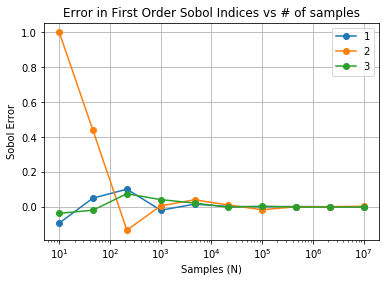

In [17]:
# Plot the error as a function of the number of samples

plt.semilogx(N_idx, S_err, '-o')
plt.grid('True')
plt.xlabel('Samples (N)')
plt.ylabel('Sobol Error')
plt.legend('123')
plt.title('Error in First Order Sobol Indices vs # of samples')

Text(0.5, 1.0, 'Error in Total Sobol Indices vs # of samples')

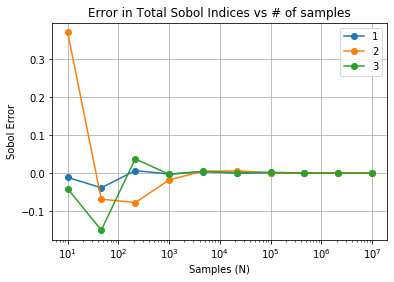

In [18]:
plt.semilogx(N_idx, T_err, '-o')
plt.grid('True')
plt.xlabel('Samples (N)')
plt.ylabel('Sobol Error')
plt.legend('123')
plt.title('Error in Total Sobol Indices vs # of samples')